# Random Forest Classifier
> Machine Learning: The basics of building a decent binary classifier on tabular data

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [RandomForest,Classification]

# Goal

The goal is to predict whether a passenger on the Titanic survived or not.  The applications for binary classification are endless and could be applied to many real world problems.  Does this patient have this disease?  Will this customer Churn?  Will price go up?  These are just a few examples.

The purpose is to give a general guide to classification.  If you get through this and want more detail, I highly recommend checking out the Tabular Chapter of Deep Learning for Coders with fastai & Pytorch by Jeremy Howard and Sylvain Gugger.  The book primarily focuses on deep learning, though decision trees are covered for tabular data.  All of the material in this guide and more is covered in much greater detail in that book.

https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527

# Setup

We are going to start with loading libraries and datasets that are needed.  I am going to skip over this as they are pretty self explanatory, but feel free to look close if you would like.

I am going to use Seaborn to load the Titanic dataset.

In [1]:
#collapse-hide
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pandas as pd
import numpy as np
from fastai2.tabular.all import *
from fastai2 import *
from sklearn.model_selection import GridSearchCV
from dtreeviz.trees import *
from scipy.cluster import hierarchy as hc


df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Data Setup


### Dependent Variable

We want to define what we are predicting, or the dependent variable.  We also see that 'Survived' and 'alive' columns are the same thing with different names.  We need to get rid of one and predict the other.

In [2]:
# survived is a duplicate of alive, so get rid of it
df.drop('survived',axis = 1, inplace=True)

dep_var = 'alive'

### Training and Validation Set Split

Best practice is to minimally have a training and validation set.  Those are the 2 that we will use for this tutorial.

+ Training Set:  This is what the model actually trains on
+ Validation Set:  This is used to gauge success of the Training
+ Test Set:  This is a held out of the total process to be an additional safeguard against overfitting

In [3]:
cond = np.random.rand(len(df))>.2
train = np.where(cond)[0]
valid = np.where(~cond)[0]
splits = (list(train),list(valid))

### Dates

We don't have any dates to deal with, but if we did we would do the following:

```df = add_datepart(df,'date')```

This would replace that date with a ton of different columns, such as the year, the day number, the day of the week, is it month end, is it month start, and more.


### Categorical Variables

##### Ordinal Categorical Variables

Some categorical variables have a natural heirarchy.  By telling pandas the order it tends to mean trees don't have to split as many times, which speeds up training times.

In [4]:
df['class'].unique()

[Third, First, Second]
Categories (3, object): [Third, First, Second]

In [5]:
classes = 'First','Second','Third'

In [6]:
df['class'] = df['class'].astype('category')
df['class'].cat.set_categories(classes, ordered=True, inplace=True)

##### Categorical Variables Final

We are not going to do some data cleaning.  The Categorify and FillMissing functions in the fastai2 library make this easy.

In [7]:
procs = [Categorify, FillMissing]

In [8]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [9]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

Let's take a look at the training and validation sets and make sure we have a good split of each.  

In [10]:
len(to.train),len(to.valid)

(691, 200)

We can now take a look and see that while we see all the same data, behind the scenes it is all numeric.  This is exactly what we need for our random forest.

In [11]:
to.show(3)

,sex,embarked,class,who,adult_male,deck,embark_town,alone,age_na,pclass,age,sibsp,parch,fare,alive
1,female,C,First,woman,False,C,Cherbourg,False,False,1.0,38.0,1.0,0.0,71.283302,yes
2,female,S,Third,woman,False,#na#,Southampton,True,False,3.0,26.0,0.0,0.0,7.925000,yes
4,male,S,Third,man,True,#na#,Southampton,True,False,3.0,35.0,0.0,0.0,8.050000,no


In [12]:
to.items.head(3)

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_na
1,1.0,1,38.0,1.0,0.0,71.283302,1,1,3,1,3,1,1,1,1
2,3.0,1,26.0,0.0,0.0,7.925000,3,3,3,1,0,3,1,2,1
4,3.0,2,35.0,0.0,0.0,8.050000,3,3,2,2,0,3,0,2,1


### Final Change

Finally, we will put just the data in xs and ys so they are in easy format to pass to models.

In [13]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

# Random Forest Model

### Initial Model

Let's start by creating a model without tuning and see how it does

In [14]:
m = RandomForestClassifier(n_estimators=100)
m = m.fit(xs,y)

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
confusion_matrix(y,m.predict(xs))

array([[433,   1],
       [  8, 249]])

Looking pretty good!  Only 7 wrong.  Let's see how it did on the validation set.

In [17]:
confusion_matrix(valid_y,m.predict(valid_xs))

array([[105,  10],
       [ 23,  62]])

Still way better than 50/50, but not quite as good.  This is because the model did not train based on this validation data so it doesn't perform nearly as well.

### Model Tuning - Grid Search

We made our first model, and it doesn't seem to predict as well as we would like.  Let's do something about that.

We are going to do a grid search.  There are many more sophisticated ways to find parameters (maybe a future post), but the grid search is easy to understand.  Basically you pick some ranges, and you try them all to see what works best.

We will use the built in gridsearch.  All we need to do is define the range of parameters, and let it find the best model.

In [18]:
parameters = {'n_estimators':range(10,20,20), 
              'max_depth':range(10,20,20),
              'min_samples_split':range(2,20,1),
              'max_features':['auto','log2']}             

In [19]:
clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)

In [20]:
clf.fit(xs,y)

/home/isaacflath/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

### Results

We can see below that the best esimator works better for prediciton the validation set than the model above did.  Success!

In [21]:
confusion_matrix(y,clf.best_estimator_.predict(xs))

array([[407,  27],
       [ 72, 185]])

In [22]:
confusion_matrix(valid_y,clf.best_estimator_.predict(valid_xs))

array([[108,   7],
       [ 23,  62]])

# Model Minimizing

Now that we have good results with a tuned model, we may want to simplify the model.  If we can simplify the model without significantly impacting accuracy, that's good for many reasons.

1. The model is easier to understand
1. Fewer variables means fewer data quality issues and more focused data quality efforts
1. It takes less resources and time to run

### Feature Importance

There are many ways to measure importance.  How often do we use a feature to split?  How high up in the tree is it used to split?  We are going to use scikit learns feature importance information.

Let's look at what features are!

In [23]:
#collapse 
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [24]:
fi = rf_feat_importance(m, xs)
fi[:5]

,cols,imp
13,fare,0.216826
10,age,0.210577
4,adult_male,0.125894
0,sex,0.089614
3,who,0.082446


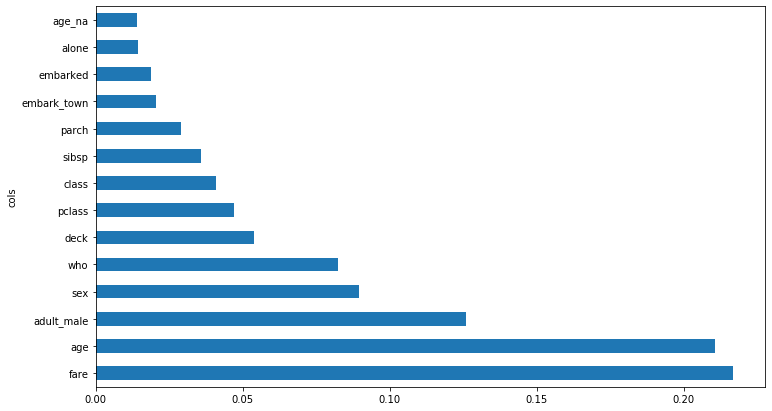

In [25]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Remove Low Important Variables

This isn't strictly neccesarry, but it is nice to simplify models if you can.  Simpler models are easier to understand and maintain, and they take less resources to run.  It is also interesting to know just how many variables are needed to predict.

In [26]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)

6

In [27]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [28]:
clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)
clf.fit(xs_imp,y)

/home/isaacflath/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

### Results

Now we see with only 6 features we still get pretty good results on on validation set.  

Now the question is whether this small loss in accuracy outweighed by a simpler and more efficient model?  That is a business question more than it is a data science question.

If you are detecting COVID-19, you probably want it to be as accurate as possible.  If you are going to predict whether someone is a cat or a dog person based on a survey for marketing purposes, small changes in accuracy probably are not as critical.

In [29]:
confusion_matrix(y,clf.best_estimator_.predict(xs_imp))

array([[390,  44],
       [ 59, 198]])

In [30]:
confusion_matrix(valid_y,clf.best_estimator_.predict(valid_xs_imp))

array([[99, 16],
       [21, 64]])

In [31]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=16,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Redundant columns

Of the 6 remaining variables, we can see that some of them are very related.  It makes sense to me that deck and fare are related.  Nicer areas probably cost more.  It makes sense to me that the person's sex has some redudancy with adult_male - the redundancy is even in the name.

In [32]:
#collapse
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

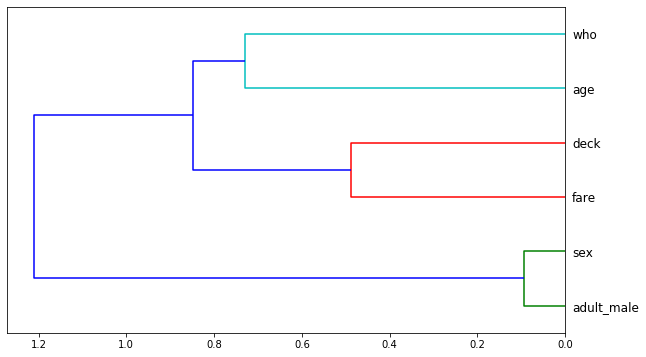

In [33]:
cluster_columns(xs_imp)

Let's experiment with removing some columns and see what we get.  We will use accuracy for our metric.

Here is out baseline:

In [34]:
#collapse
print("accuracy: ")
(confusion_matrix(valid_y,clf.best_estimator_.predict(valid_xs_imp))[0,0] +\
    confusion_matrix(valid_y,clf.best_estimator_.predict(valid_xs_imp))[1,1] )/\
    confusion_matrix(valid_y,clf.best_estimator_.predict(valid_xs_imp)).sum()

accuracy: 


0.815

In [35]:
#collapse
def get_accuracy(x,y,valid_x,valid_y):
    m = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    m.fit(xs_imp,y)
    print((confusion_matrix(valid_y,m.predict(valid_xs_imp))[0,0] +\
    confusion_matrix(valid_y,m.predict(valid_xs_imp))[1,1] )/\
    confusion_matrix(valid_y,m.predict(valid_xs_imp)).sum())

We will now loop through each of the remaining variables and train a model and print out the accuracy score.

Judging by the scores below, removing any 1 variable does not significantly reduce the accuracy.  This means that we have redundant columns that can likely be trimmed.  Sex seems to be a column we would definitely keep as removing it have the most impact on accuracy.

From this we can remove variables and iterate through to continue simplifying as much as possible.

In [36]:
#collapse
variables = ['sex','adult_male','who','age','deck','fare']

for variable in variables:
    print('drop '+variable+' accuracy:')
    get_accuracy(xs_imp.drop(variable, axis=1),
                 y,
                 valid_xs_imp.drop(variable, axis=1),
                 valid_y)


drop sex accuracy:
0.815
drop adult_male accuracy:
0.825
drop who accuracy:
0.81
drop age accuracy:
0.855
drop deck accuracy:
0.835
drop fare accuracy:
0.825
